# In this project I used dataset from the aerospace industry. Problem wich i try to resolve -  find the best parameters of airfoil. Performance optimization can be applied to understand the behavior of airfoils and make designs with reduced noise.

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ydata_profiling
from sklearn.metrics import SCORERS
import pickle
import flask
from sklearn.metrics import mean_squared_error, roc_auc_score, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


#The following inputs:
1. Frequency, in Hertzs. 
2. Angle of attack, in degrees. 
3. Chord length, in meters.
4. Free-stream velocity, in meters per second. 
5. Suction side displacement thickness, in meters. 

#The output is:
6. Scaled sound pressure level, in decibels. 

In [12]:
df = pd.read_csv('airfoil_self_noise.dat', sep='\t', header=None)

In [13]:
df.columns =['Frequency','Angle of attack','Chord length','Free-stream velocity','Suction side displacement thickness','Scaled sound pressure level']

In [14]:
df.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness,Scaled sound pressure level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [15]:
df.isnull().sum()

Frequency                              0
Angle of attack                        0
Chord length                           0
Free-stream velocity                   0
Suction side displacement thickness    0
Scaled sound pressure level            0
dtype: int64

In [16]:
y = df.iloc[:,-1]

In [17]:
X = df.iloc[:,0:5]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7 ,test_size=0.3, random_state=42)

In [19]:
X_train.head()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness
1191,2500,17.4,0.0254,39.6,0.017221
1350,2500,6.7,0.1016,71.3,0.004783
1276,4000,0.0,0.1016,39.6,0.001463
527,630,2.7,0.1524,39.6,0.002948
199,16000,0.0,0.2286,71.3,0.002143


## The scatterplot below shows some correletion between:
### "Angle of attak" and "Suction side", "Chord length" and "angle of attack"
### How we can see, it's regression problem.

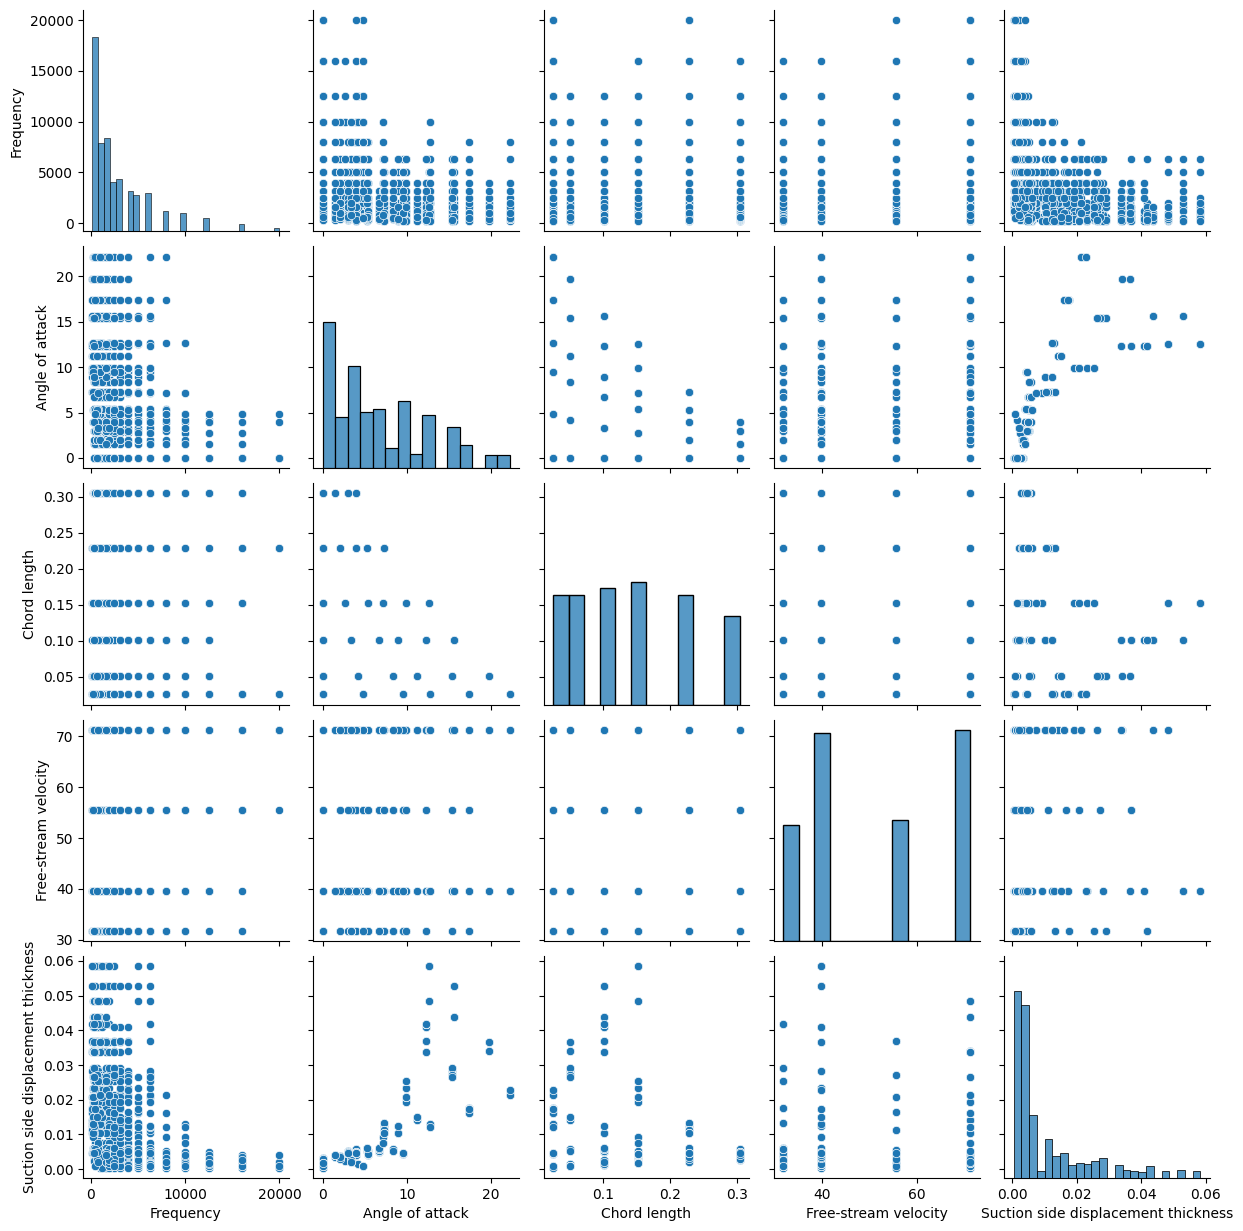

In [20]:
sns.pairplot(X_train)

## Lets aprove by corr() func:
### coeff between "Suction side displacement thickness" and "Angle of attack" : 0,76
### coeff between "Chord length" and "Angle of attack":  -0,5

In [21]:
X_train.corr()

,Frequency,Angle of attack,Chord length,Free-stream velocity,Suction side displacement thickness
Frequency,1.000000,-0.274765,-0.000919,0.124310,-0.238811
Angle of attack,-0.274765,1.000000,-0.500583,0.051093,0.761265
Chord length,-0.000919,-0.500583,1.000000,0.009959,-0.224177
Free-stream velocity,0.124310,0.051093,0.009959,1.000000,-0.009185
Suction side displacement thickness,-0.238811,0.761265,-0.224177,-0.009185,1.000000


## Let's see correlations by profile_report func from pandas.

In [22]:
report = df.profile_report(
    sort=None, html={"style": {"full_width": True}}, progress_bar=False
)
report

## "Scaled sound pressure level" column has some outliers below ~105 value

Text(0.5, 1.0, "Interquartile range of 'Scaled sound pressure level'")

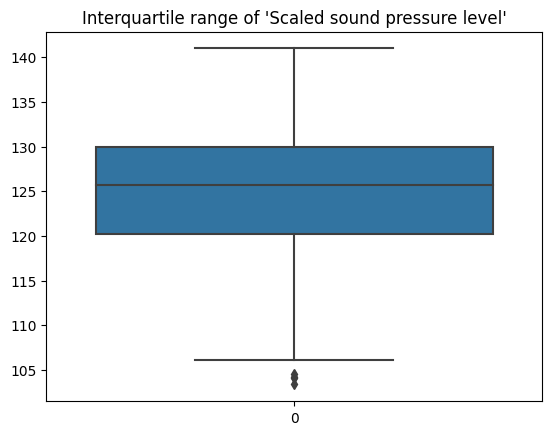

In [23]:
pl =sns.boxplot(df['Scaled sound pressure level'])
pl.set_title("Interquartile range of 'Scaled sound pressure level'")

In [24]:
df['Scaled sound pressure level'] = df[df['Scaled sound pressure level'] > 106]['Scaled sound pressure level']

### Now looks better!

Text(0.5, 1.0, "Interquartile range of 'Scaled sound pressure level'\n without outliers")

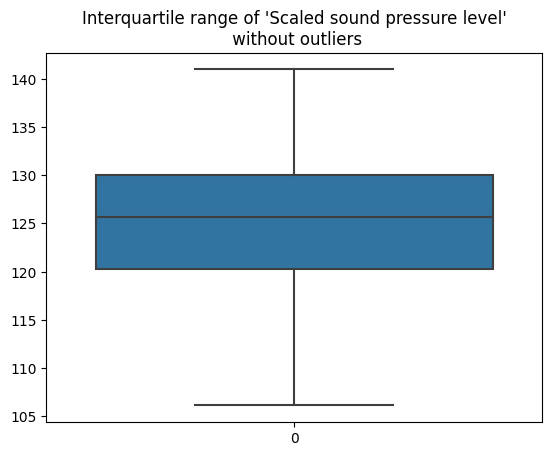

In [25]:
pl2 = sns.boxplot(df['Scaled sound pressure level'])
pl2.set_title("Interquartile range of 'Scaled sound pressure level'\n without outliers")

## In this case we try to use DecisionTreeRegressor and RandomForestRegressor, and after we will compare the results of this algorithms.

# DecisionTreeRegressor

In [26]:
dt = DecisionTreeRegressor()
params = [{'criterion' : ["mse", "friedman_mse", "mae", "poisson"],
           'max_depth' : [2, 10, 12, 15, 20, 40, 60],
           'splitter' : ['best', 'random'],
           'min_samples_split' : [2,4,6,8,10,20,30],
           'max_features' : ['auto', 'sqrt', 'log2']
          }]
gridcv_dt = GridSearchCV(dt, param_grid=params, cv=5)

In [27]:
gridcv_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'criterion': ['mse', 'friedman_mse', 'mae',
                                        'poisson'],
                          'max_depth': [2, 10, 12, 15, 20, 40, 60],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_split': [2, 4, 6, 8, 10, 20, 30],
                          'splitter': ['best', 'random']}])

In [28]:
gridcv_dt.best_score_

0.8301942943019196

In [29]:
best_params_dtr = gridcv_dt.best_params_

In [30]:
best_params_dtr

{'criterion': 'mae',
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_split': 2,
 'splitter': 'random'}

In [31]:
dtr = DecisionTreeRegressor(criterion=best_params_dtr['criterion'], 
                            max_depth=best_params_dtr['max_depth'], 
                            max_features=best_params_dtr['max_features'], 
                            min_samples_split=best_params_dtr['min_samples_split'],
                            splitter=best_params_dtr['splitter']
                           )

In [32]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=40, max_features='auto',
                      splitter='random')

In [33]:
score_dtr = dtr.score(X_train, y_train)

In [34]:
score_dtr

1.0

In [35]:
y_pred_dtr = dtr.predict(X_test)

In [36]:
mse_dtr = mean_squared_error(y_test, y_pred_dtr)
mae_dtr = mean_absolute_error(y_test, y_pred_dtr)
r2s_dtr = r2_score(y_test, y_pred_dtr)
print("MSE: ", np.round(100-mse_dtr,0),'%')
print("RMSE: ", np.round(100-mse_dtr**(1/2.0)), '%')
print("MAE: ", np.round(100-mae_dtr, 0), '%') 
print("R2: ", np.round(100-r2s_dtr, 0), '%')

MSE:  92.0 %
RMSE:  97.0 %
MAE:  98.0 %
R2:  99.0 %


Text(0, 0.5, 'y_pred')

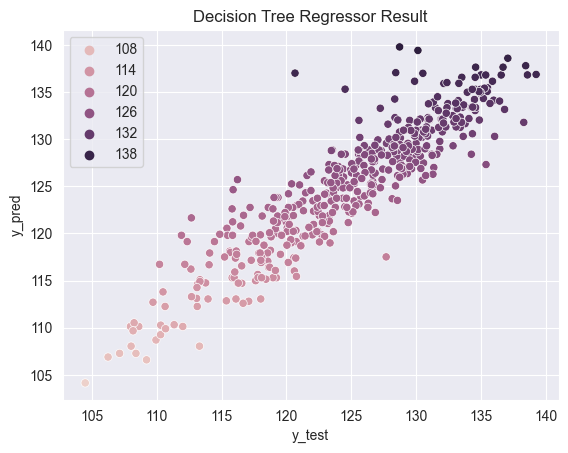

In [37]:
sns.set_style("darkgrid")
res_dtr = sns.scatterplot(x=y_test, y=y_pred_dtr, hue=y_pred_dtr)
res_dtr.set_title('Decision Tree Regressor Result')
res_dtr.set_xlabel('y_test')
res_dtr.set_ylabel('y_pred')


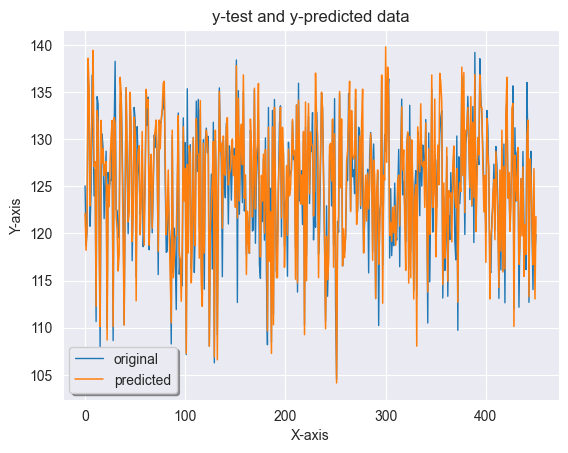

In [38]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred_dtr, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

In [39]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

# RandomForestRegressor

In [41]:
rf = RandomForestRegressor()
params2 = [{'criterion' : ["mae", "mse"],
           'max_depth' : [2, 5, 10, 15, 30, 50, 100],
           'min_samples_split' : [2, 4],
           'max_features' : ['auto', 'sqrt', 'log2'],
          }]
gridcv_rf = GridSearchCV(rf, param_grid=params2, cv=5, n_jobs=2)

In [42]:
gridcv_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid=[{'criterion': ['mae', 'mse'],
                          'max_depth': [2, 5, 10, 15, 30, 50, 100],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'min_samples_split': [2, 4]}])

In [43]:
best_params_rf = gridcv_rf.best_params_

In [44]:
best_params_rf

{'criterion': 'mae',
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_split': 2}

In [45]:
gridcv_rf.best_score_

0.9102217956554238

In [46]:
best_params_rf

{'criterion': 'mae',
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_split': 2}

In [47]:
rfr = RandomForestRegressor(
    criterion=best_params_rf['criterion'], 
    max_depth=best_params_rf['max_depth'], 
    max_features=best_params_rf['max_features'], 
    min_samples_split=best_params_rf['min_samples_split']
)

In [48]:
rfr.fit(X_train, y_train)

RandomForestRegressor(criterion='mae', max_depth=100)

In [49]:
score = rfr.score(X_train, y_train)

In [50]:
score

0.9870884010796355

In [51]:
y_pred_rfr = rfr.predict(X_test)

In [52]:
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
r2s_rfr = r2_score(y_test, y_pred_rfr)
print("MSE: ", np.round(100-mse_rfr,0),'%')
print("RMSE: ", np.round(100-mse_rfr**(1/2.0)), '%')
print("MAE: ", np.round(100-mae_rfr, 0), '%') 
print("r2_score: ", np.round(100-r2s_rfr, 0), '%')

MSE:  97.0 %
RMSE:  98.0 %
MAE:  99.0 %
r2_score:  99.0 %


Text(0, 0.5, 'y_pred')

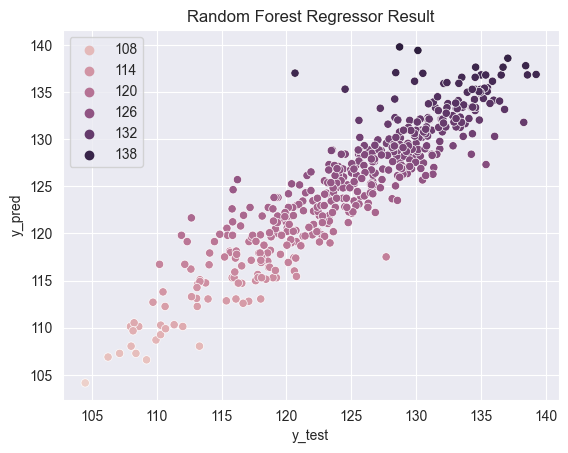

In [53]:
sns.set_style("darkgrid")
res_dtr = sns.scatterplot(x=y_test, y=y_pred_dtr, hue=y_pred_dtr)
res_dtr.set_title('Random Forest Regressor Result')
res_dtr.set_xlabel('y_test')
res_dtr.set_ylabel('y_pred')

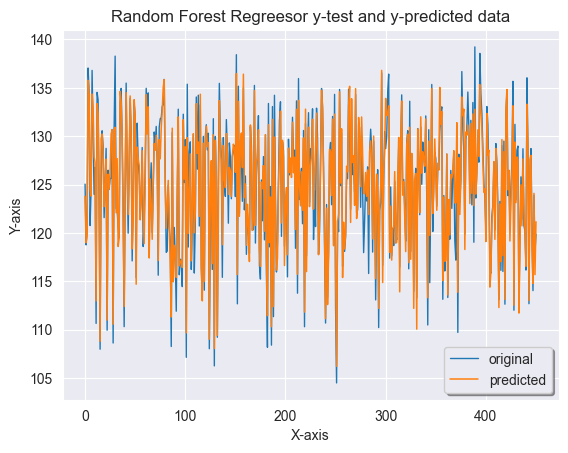

In [54]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred_rfr, linewidth=1.1, label="predicted")
plt.title("Random Forest Regreesor y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

Save our models by pickle:

In [94]:
pickle.dump(dtr, open('dtr.pkl', 'wb'))
pickle_model_dtr = pickle.load(open('dtr.pkl', 'rb'))
y_pred_dtr = pickle_model_dtr.predict(X_test)

pickle.dump(rfr, open('rfr.pkl', 'wb'))
pickle_model_rfr = pickle.load(open('rfr.pkl', 'rb'))
y_pred_rfr = pickle_model_rfr.predict(X_test)

Minimal value sound pressure - 106.21815
Medium value sound pressure - 120.69872
High value sound pressure - 136.47661

In [129]:
y_elems = np.round(y_pred_rfr, 4)

In [132]:
elem1 = y_elems.tolist().index(106.2181)
elem2 = y_elems.tolist().index(120.6987)
elem3 = y_elems.tolist().index(136.4766)

In [133]:
print(elem1,elem2,elem3)

251 308 151


Here we can see the specific values in each sound pressure levels

In [134]:
X_test.iloc[251,:]

Frequency                              4000.000000
Angle of attack                          12.600000
Chord length                              0.152400
Free-stream velocity                     39.600000
Suction side displacement thickness       0.058411
Name: 722, dtype: float64

In [135]:
X_test.iloc[308,:]

Frequency                              630.000000
Angle of attack                          4.800000
Chord length                             0.025400
Free-stream velocity                    39.600000
Suction side displacement thickness      0.000907
Name: 1031, dtype: float64

In [136]:
X_test.iloc[151,:]

Frequency                              630.000000
Angle of attack                          8.900000
Chord length                             0.101600
Free-stream velocity                    71.300000
Suction side displacement thickness      0.010309
Name: 1382, dtype: float64

# Let's try choose our values for each columns, for find minimal sound pressure, based on our model

In [170]:
pickle_model_dtr.predict([[5000, 4, 0.001, 10, 0.1]])

array([104.13])

In [223]:
pickle_model_rfr.predict([[6000, 16, 0.6, 5, 0.09]])

array([104.11772])

# Counclusion: 
## 1. We analyzed dataset and find some correlation.
## 2. We handled ouliers from label data.
## 3. We found best parameters for our models. 
## 4.DecisionTree and RandomForest Regressors both good for these data
## 5. Our model have 98-99 persent accuracy, it's very high.
## 6. We can use our models in specific airspace tasks for find the best sound pressure level. 